In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font='SimHei', font_scale=2.5)
plt.rcParams['axes.grid'] = False

#import numpy as np

#import pandas as pd
#pd.options.display.max_rows = 20

#import sklearn

#import itertools

#import logging
#logger = logging.getLogger()

#from IPython.display import SVG
def show_image(filename, figsize=None, res_dir=True):
    if figsize:
        plt.figure(figsize=figsize)

    if res_dir:
        filename = './res/{}'.format(filename)

    plt.imshow(plt.imread(filename))

10 Sequence Modeling: Recurrent and Recursive Nets
==============

RNN: to process sequential data

traditionaly fully connected feedforward network: separate parameters at each position.
=> recurrent neural network: shares the same parameters across several steps.

### 10.1 Unfoliding Computational Graphs

recurrent neural networks: $h^{(t)} = f(h^{(t-1)}, x^{(t)}; \theta)$

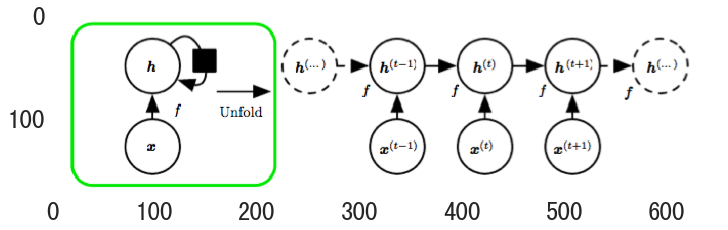

In [2]:
show_image('fig10_2.png', figsize=(12, 5))

two major advantages:
+ same input size even for a variable-length sequence.
+ use the **same** transition function $f$ with the same parameters at every time step.

unfolded graph: computing gradients

### 10.2 Recurrent Neural Networks

Different recurrent networks:

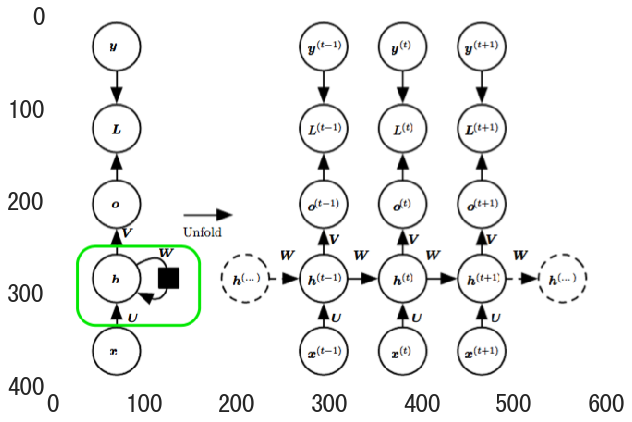

In [6]:
# A.
show_image('fig10_3.png', figsize=(10, 8))

\begin{align}
    a^t &= b + W h^{(t-1)} + U x^t \\
    h^t &= \tanh(a^t) \\
    o^t &= c + V h^t \\
    \hat{y}^t &= \operatorname{softmax}(o^t) \\
\end{align}

The total loss for a given sequence of $x$ values paired with a sequence of $y$ values would be just the sum of the losses over all the time steps:

\begin{align}
    &L \left ( \{x^1, \cdots, x^\tau\}, \{y^1, \cdots, y^\tau\}) \right ) \\
    &= \sum_t L^t \\
    &= - \sum_t \log p_{\text{model}} \left ( y^t \, | \, \{x^1, \cdots, x^\tau\} \right ) \\
\end{align}

So the back-propagation algorithm need $O(\tau)$ running time moving right to left through the graph, and also $O(\tau)$ memory cost to store the intermediate states. => back-propagation through time (BPTT): **powerful but also expensive to train**

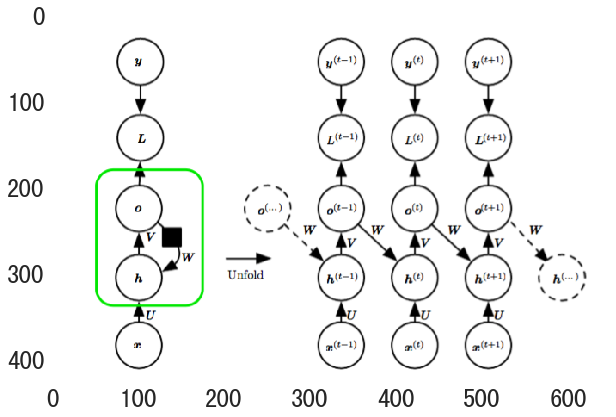

In [2]:
# B.
show_image('fig10_4.png', figsize=(10, 8))

**advantage** of eliminating hidden-to-hidden recurrence: decouple all the time steps (replace predition by its ground truth in sample for $t-1$)
=> teacher forcing

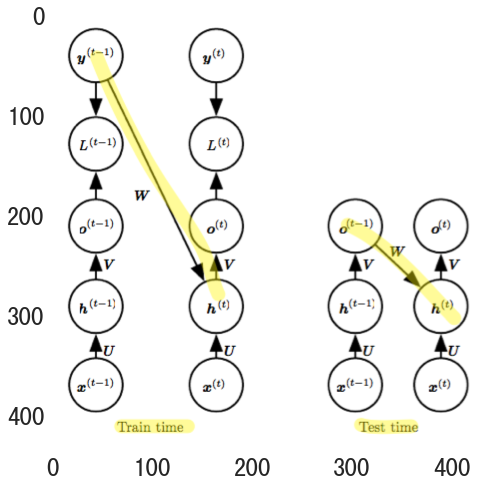

In [4]:
show_image('fig10_6.png', figsize=(10, 8))

**disadvantage**: *open-loop* network (outputs fed back as input) => inputs are quite different between training and testing.

+ mitigate the problem:
  1. train with both teacher-forced inputs and with free-running inputs.
  2. randomly choose to use generated values or actual data as input.

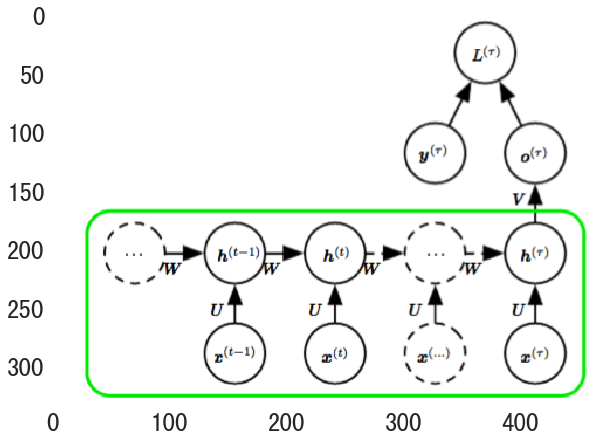

In [7]:
# C.
show_image('fig10_5.png', figsize=(10, 8))

#### 10.2.2 Computing the Gradient in a Recurrent Neural Network

1. calculate the gradients on the internal nodes.
2. calculate the gradients on the paramter nodes.
   Because the parameters are shared across many time steps, we introduce dummy variables $W^t$ that are defined to be copies of $W$ but with each $W^t$ used only at time step $t$.

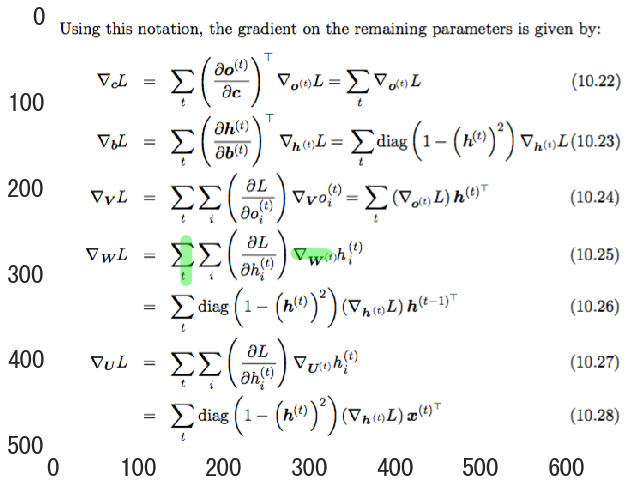

In [8]:
show_image("formula_gradient.png", figsize=(12, 8))

#### 10.2.3 Recurrent Networks as Directed Graphical Models

Mean squared error: the cross-entropy loss associated with an output distribution that is a unit Gaussian.

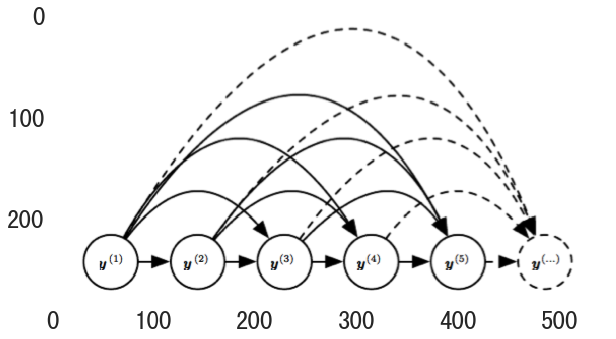

In [9]:
show_image('fig10_7.png', figsize=(10, 8))

RNNs obtain the same full connectivity above but efficient parametrization, as illustrated below:

+ Incorporating the $h^t$ nodes in the graphical model decouples the past and the future.
+ Variable $y^i$ in the distant past may influence $y^t$ via its effect on $h$.
+ Assume same conditional probability distributions at each time step. $\gets$ parameter sharing

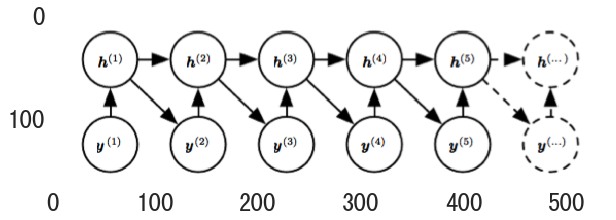

In [10]:
show_image('fig10_8.png', figsize=(10, 8))

determining the length of the sequence:
+ add a special symol in training sample.
+ introduce an extra Bernoulli output: decision to either continue generation or halt at each time step.
+ add an extra output to predict length $\tau$.

#### 10.2.4 Modeling Sequences Conditioned on Context with RNNs

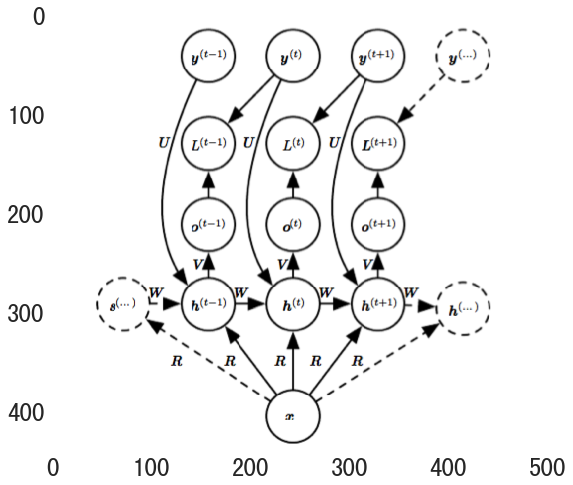

In [13]:
# fixed-length vector x, share R
show_image('fig10_9.png', figsize=(10, 8))

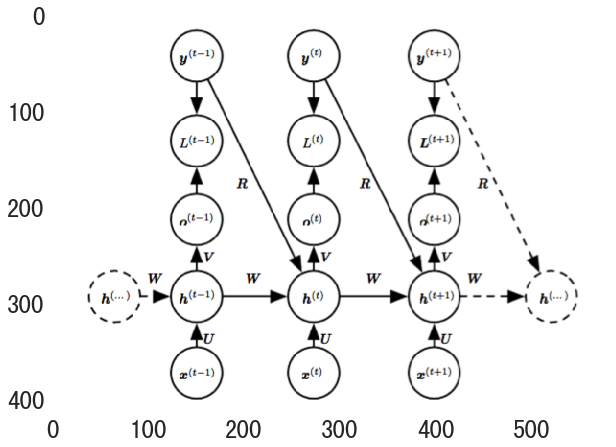

In [14]:
# variable-length sequence
show_image('fig10_10.png', figsize=(10, 8))

restriction: the length of both sequences $x$ and $y$ must be the same.

### 10.3 Bidirectional RNNs

For speech recognition or handwriting reccognition, prediction depends on the **whole** input sequence => bidirectional

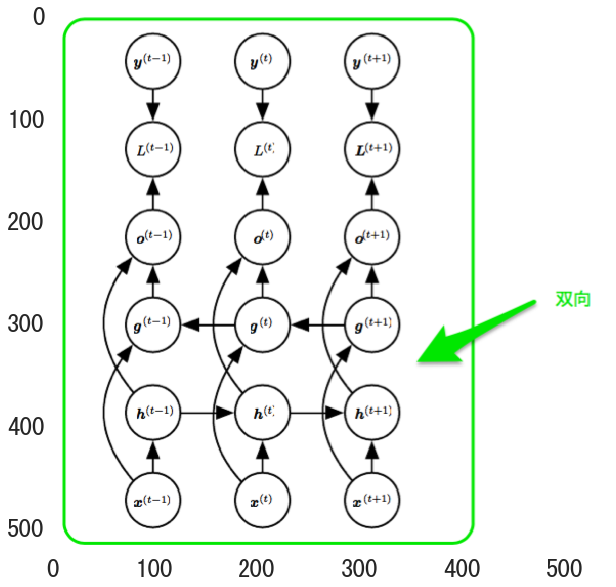

In [8]:
show_image("fig10_11.png", figsize=(10, 12))

### 10.4 Encoder-Decoder Sequence-to-Sequence Architectures

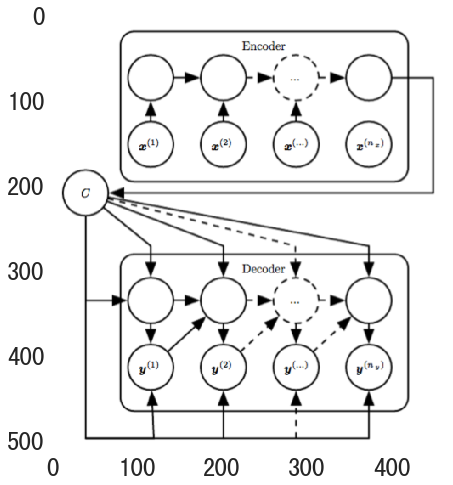

In [7]:
show_image("fig10_12.png", figsize=(10, 8))

$C$: context, a vector or sequence of vectors that summarize the input sequence $X$.

limitation: $C$ cannot be so small that it cannot properly summarize a long sequence.

### 10.5 Deep Recurrent Networks

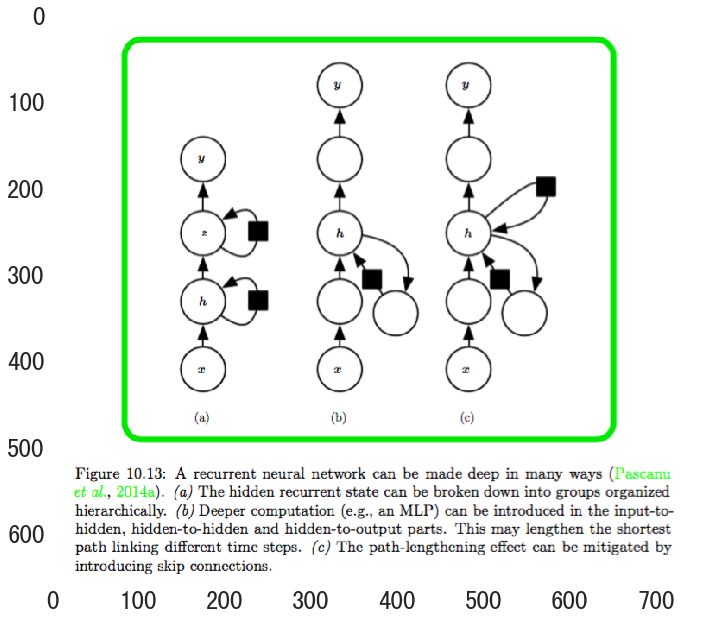

In [11]:
show_image("fig10_13.png", figsize=(12, 15))

### 10.6 Recursive Neural Networks

 | structure | depth 
 ----|----|----
 RNN | chain-like | $\tau$
 recursive neural network | tree | $\log \tau$
 
 Open question: How to best structure the tree?

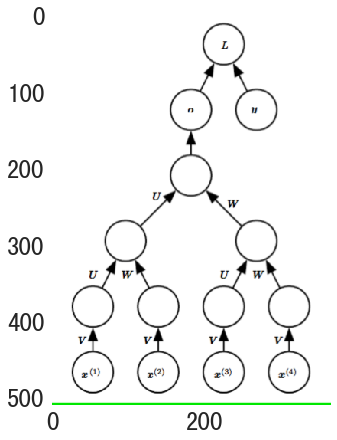

In [13]:
show_image("fig10_14.png", figsize=(5, 12))

### 10.7 The Challenge of Long-Term Dependencies

basic problem: gradients => vanish / explode (over many stages)

\begin{align}
    h^t &= (W^t)^T h^0 \\
    W &= Q \Lambda A^T \\
    h^t &= Q^T \Lambda^t Q h^0
\end{align}

In $\Lambda^t$, $v < 1 \implies  0$. The largest eigenvalue dominates. 

=> Any component of $h^0$ that is not aligned with the largest eignevector => discard.

The problem is particular to RNN <= they share the same weight at each time step.

The remaining sections describe approaches to overcoming the problem:

### 10.8 Echo State Networks

Set the input and recurrent weights such that the dynamic system is near the edge of stability, and ONLY learn the output weights.

### 10.9 Leaky Units and Other Strategies for Multiple Time Scales

design a model that operates at multiple time scalse => hanlde both near past and distant past => mitigate long-term dependencies

+ Adding Skip Connections through Time
+ Leaky Units and a Spectrum of Different Time Scales: $u^t = \alpha u^{t-1} + (1 - \alpha) v^t$
+ Removing Connections

### 10.10 The Long Short-Term Memory and Other Gated RNNs

creating paths through time:
+ accumulate information over a long duration.
+ forget the old state if necessary.

LSTM

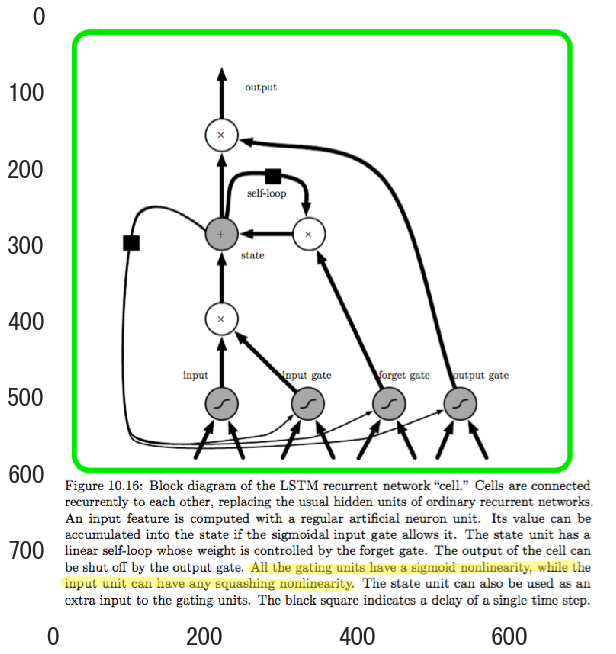

In [3]:
show_image("fig10_16.png", figsize=(10, 15))

GRU: gated recurrent units

a single gating unit simultaneously controls the forgetting factor and the decision to update the state unit

\begin{equation}
    h_i^t = u_i^{(t-1)} h_i^{(i-1)} + (1 - u_i^{(t-1)} \sigma \left ( b_i + \sum_j U_{i, j} x_j^{(t-1)} + \sum_j W_{i, j} r_j^{(t-1)} h_j^{(t-1)} \right )
\end{equation}

### 10.11 Optimization for Long-Term Dependencies

+ second-order optimization: second derivatives may vanish at the same time that first derivates vanish.
+ clipping gradients before updating:  <= exploding gradients
  1. clip the parameter gradient element-wise.
  2. clip the norm $\|g\|$ of the gradient $g$.
+ regularizing to encourage information flow. <= vanishing gradients

### 10.12 Explicit Memory

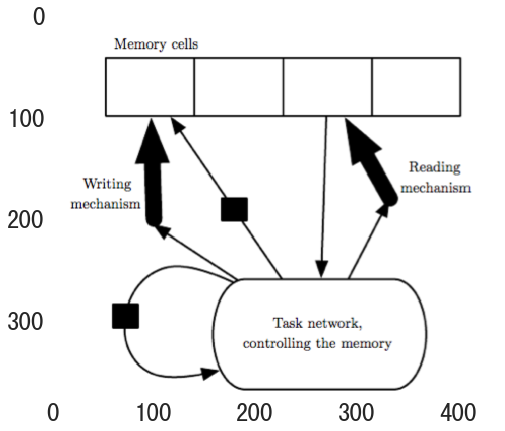

In [6]:
show_image("fig10_18.png", figsize=(8, 12))